# RAG chatbot powered by 🔗 Langchain, OpenAI, Google Generative AI and Hugging Face 🤗

## Table of Contents

1. [Introduction](#intro)<br>
2. [Import](#import)<br>
3. [API keys](#apikeys)<br>
4. [Conversational RAG Architecture](#rag_architecture)<br>
5. [Conversational RAG Implementation](#rag_impl)<br>
    5.1. [Document loaders](#document_loaders)<br>
    5.2. [Text Splitters](#text_splitters)<br>
    5.3. [Vectorsores and Embeddings](#vectorstores)<br>
    5.4. [Retrievers](#retrievers)<br>
    5.5. [Retrieval: put it all together](#retrieval)<br>
    5.6. [Conversational retrieval Chain with memory](#conv_retrieval_chain)<br>
6. [Step-by-Step approach to Conversational Retrieval Chain](#conv_retrieval_chain_details)<br>
7. [Invoke ConversationalRetrievalChain](#conv_retrieval_chain)<br>
8. [Streamlit applicationn](#streamlit_app)<br>
9. [Concluding](#conclusion)

# <a class="anchor" id="intro">Introduction</a>

Although Large Language Models (LLMs) are powerful and capable of generating creative content, they can produce outdated or incorrect information as they are trained on static data. To overcome this limitation, Retrieval Augmented Generation (RAG) systems can be used to connect the LLM to external data and obtain more reliable answers.

The aim of this project is to build a RAG chatbot in Langchain powered by [OpenAI](https://platform.openai.com/overview), [Google Generative AI](https://ai.google.dev/?hl=en) and [Hugging Face](https://huggingface.co/) **APIs**. You can can upload documents in txt, pdf, CSV, or docx formats and chat with your data. Relevant documents will be retrieved and sent to the LLM along with your follow-up questions for accurate answers.

Throughout this project, we examined each component of the RAG system from document loader to conversational retrieval chain. Additionally, we developed a user interface using [streamlit](https://streamlit.io/) application.

# <a class="anchor" id="import">Import</a>

In [1]:
# !pip install langchain==0.1.4
# !pip install langchain-google-genai==0.0.6
# !pip install langchain-openai==0.0.2.post1
# !pip install docx2txt
# !pip install chromadb
# !pip install huggingface_hub
# !pip install cohere
# !pip install streamlit==1.28.0
# !pip install --upgrade tiktoken
# !pip install Pillow
# !pip install numpy

In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import os, tempfile, glob, random
from pathlib import Path
from IPython.display import Markdown
from PIL import Image
from getpass import getpass
import numpy as np
from itertools import combinations

# LLM: openai and google_genai
import openai
from langchain_openai import OpenAI, OpenAIEmbeddings, ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_google_genai import GoogleGenerativeAIEmbeddings

# LLM: HuggingFace
from langchain_community.embeddings import HuggingFaceInferenceAPIEmbeddings
from langchain_community.llms import HuggingFaceHub

# langchain prompts, memory, chains...
from langchain.prompts import PromptTemplate, ChatPromptTemplate
from langchain.chains import ConversationalRetrievalChain
from langchain_community.chat_message_histories import StreamlitChatMessageHistory
from operator import itemgetter
from langchain.memory import ConversationBufferMemory
from langchain_core.runnables import RunnableLambda, RunnableParallel, RunnablePassthrough
from langchain.schema import Document, format_document
from langchain_core.messages import AIMessage, HumanMessage, get_buffer_string

# Document loaders
from langchain_community.document_loaders import (
    PyPDFLoader,
    TextLoader,
    DirectoryLoader,
    CSVLoader,
    UnstructuredExcelLoader,
    Docx2txtLoader,
)

# Text Splitter
from langchain.text_splitter import RecursiveCharacterTextSplitter, CharacterTextSplitter

# OutputParser
from langchain_core.output_parsers import StrOutputParser

# Chroma: vectorstore
from langchain_community.vectorstores import Chroma

# Contextual Compression
from langchain.retrievers.document_compressors import DocumentCompressorPipeline
from langchain.text_splitter import CharacterTextSplitter
from langchain_community.document_transformers import EmbeddingsRedundantFilter,LongContextReorder
from langchain.retrievers.document_compressors import EmbeddingsFilter
from langchain.retrievers import ContextualCompressionRetriever

# Cohere
from langchain.retrievers.document_compressors import CohereRerank
from langchain_community.llms import Cohere

In [2]:
# Data Directories: where temp files and vectorstores will be saved

TMP_DIR = Path("./data").resolve().parent.joinpath("data", "tmp")
LOCAL_VECTOR_STORE_DIR = Path("./data").resolve().parent.joinpath("data", "vector_stores")

# <a class="anchor" id="apikeys">API Keys</a>

For our application, we will need 4 API keys:
- **OpenAI** API key: [Get an API key](https://platform.openai.com/account/api-keys)
- **Google** API key: [Get an API key](https://makersuite.google.com/app/apikey)
- **🤗 Hugging Face Hub** API token: [Get an Access Token](https://huggingface.co/settings/tokens)
- **Cohere** API key: [Get an API key](https://dashboard.cohere.com/api-keys)

>For security reasons, We will **NOT include** our secret keys in the notebook.
>
>First, we need to add the environment variables: `OPENAI_API_KEY`, `GOOGLE_API_KEY`, `HUGGINGFACEHUB_API_TOKEN` and `COHERE_API_KEY`.
>
>Next, we load them as follows.

In [3]:
# Get environment variables: OPENAI_API_KEY, GOOGLE_API_KEY, HUGGINGFACEHUB_API_TOKEN, and COHERE_API_KEY

def get_environment_variable(key):
    if key in os.environ:
        value = os.environ.get(key)
        print(f"\n[INFO]: {key} retrieved successfully.")
    else :
        print(f"\n[ERROR]: {key} is not found in your environment variables.") 
        value = getpass(f"Insert your {key}")
    return value

openai_api_key = get_environment_variable("OPENAI_API_KEY")
google_api_key = get_environment_variable("GOOGLE_API_KEY")
HF_key = get_environment_variable("HUGGINGFACEHUB_API_TOKEN")
cohere_api_key = get_environment_variable("COHERE_API_KEY")


[INFO]: OPENAI_API_KEY retrieved successfully.

[INFO]: GOOGLE_API_KEY retrieved successfully.

[INFO]: HUGGINGFACEHUB_API_TOKEN retrieved successfully.

[INFO]: COHERE_API_KEY retrieved successfully.


# Why RAG?

LLMs lack access to real-time information and user-specific data. 

Here is an example: In this [paper](https://arxiv.org/abs/2401.13795?utm_source=substack&utm_medium=email), the authors present "Diffuse to Choose", a novel diffusion-based image-conditioned inpainting model. 

Let's ask ChatGPT what "Diffuse to Choose" is?

In [5]:
# Let's start with a direct API call to OpenAI.
# https://platform.openai.com/docs/quickstart?context=python

from openai import OpenAI
try:
    client = OpenAI() # defaults to getting the key using os.environ.get("OPENAI_API_KEY")
except:
    client = OpenAI(api_key=openai_api_key) # if OPENAI_API_KEY is not created as environment variable

completion = client.chat.completions.create(
  model="gpt-3.5-turbo",
  messages=[
    {"role": "system", "content": 'what is "Diffuse to Choose"?'},
  ]
)

print(completion.choices[0].message.content)

"Diffuse to Choose" is not a commonly used phrase or term. Without further context, it is difficult to determine its exact meaning. It may be a combination of the words "diffuse" and "choose," suggesting that one should approach decision-making in a calm and open-minded manner. Diffusing could refer to dispersing or releasing tension, emotions, or thoughts before making a choice, allowing for clearer thinking and consideration of different options. However, it is important to note that this interpretation is speculative, as the phrase is not widely recognized.


# <a class="anchor" id="rag_architecture">Conversational RAG Architecture</a>

Here is an illustration of the architecture and the workflow of the RAG chatbot that we will be building using Langchain.

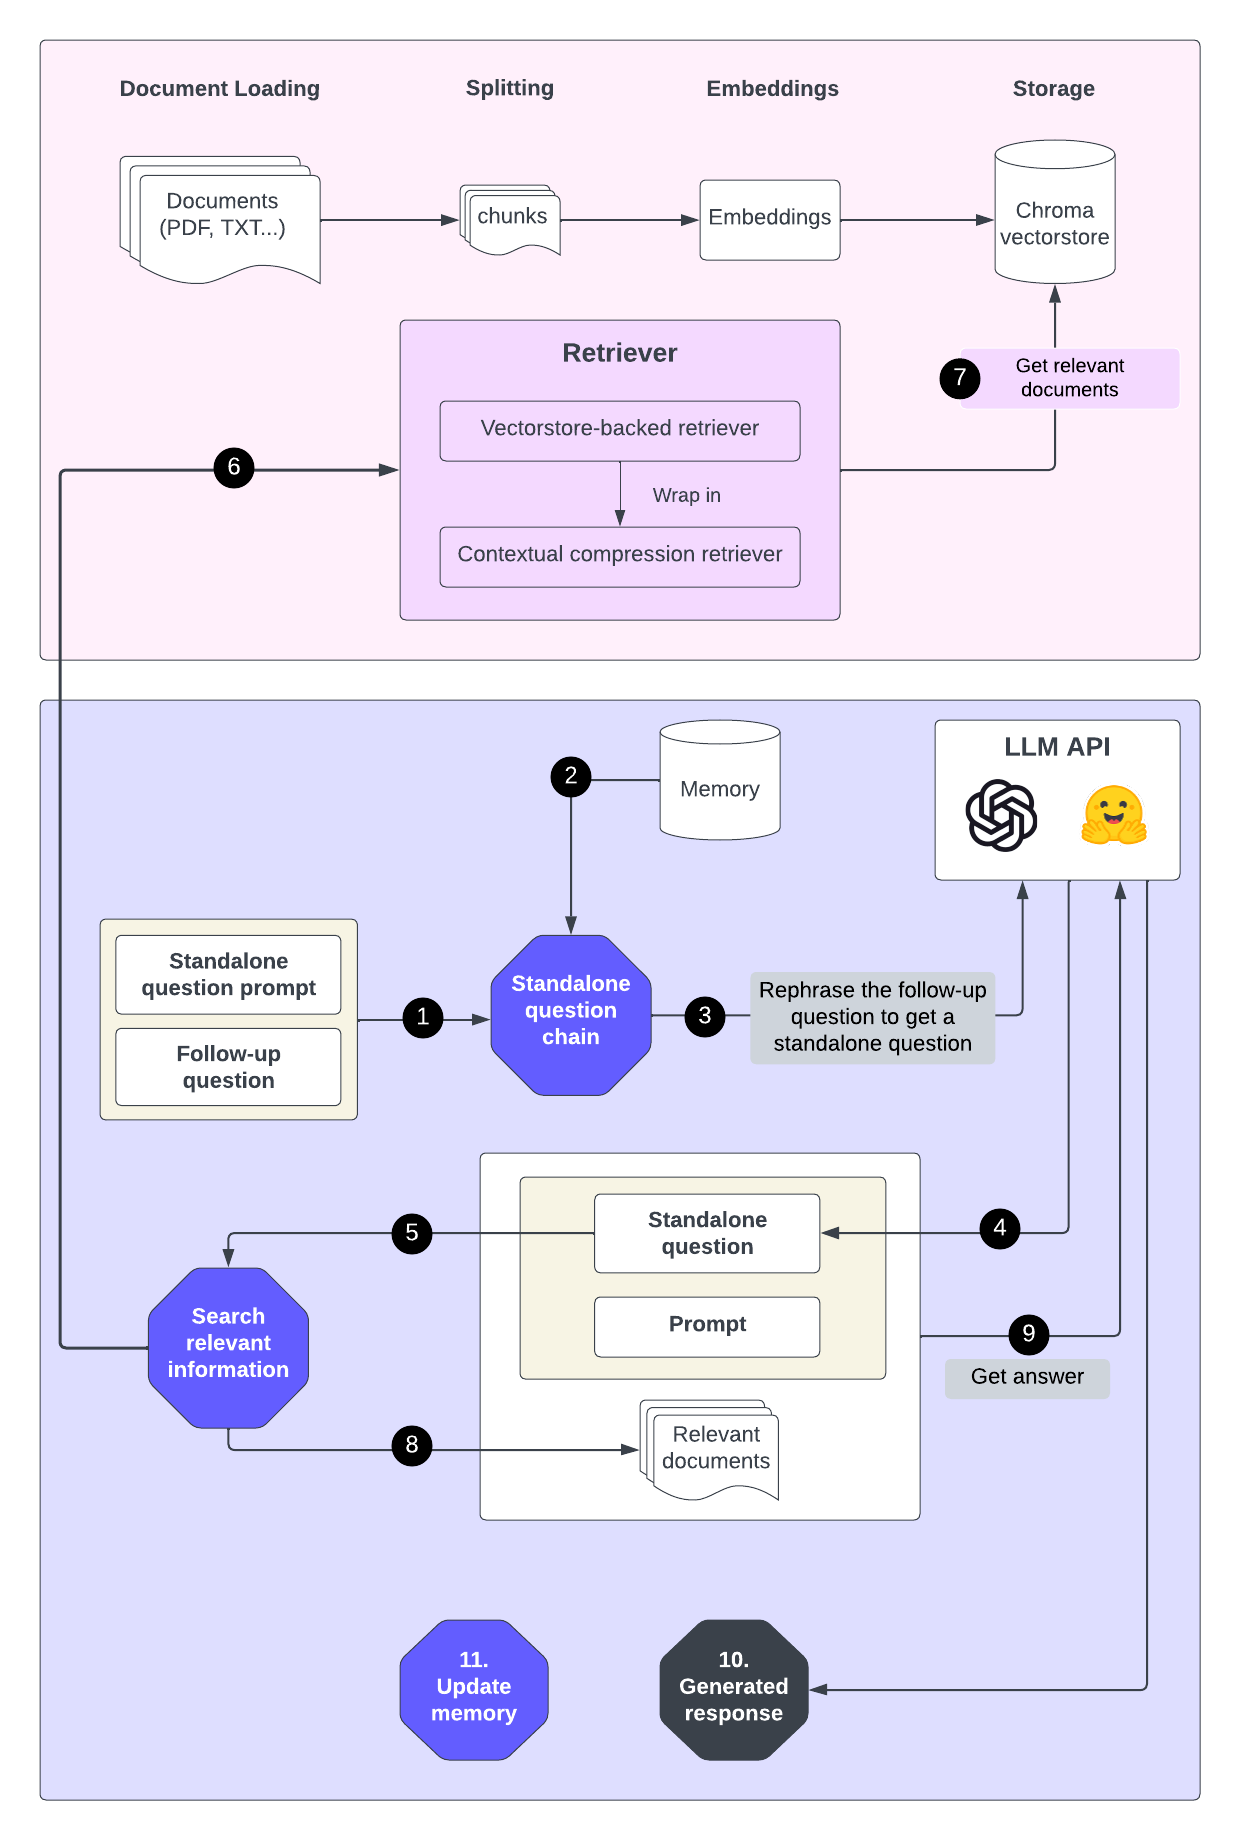

In [6]:
Image.open("./data/docs/RAG_architecture.png")

There are two main blocks in the RAG architecture:
- The first block includes a document loader, text splitter, vector store, and retriever. It loads external documents, converts them into numerical representations (embeddings), and stores them in a vector store (Chroma vector database).
- The second block comprises LLMs, memory, and prompt templates. It interfaces with the retriever to retrieve documents similar to the query, augments the LLM prompt with these documents, and communicates with the LLM to obtain a relevant answer.

Here are the main steps in the RAG workflow:

- **(1), (2), (3) and (4):** The standalone question prompt is formated with the follow-up question and chat history and passed to the LLM, which will rephrase the follow-up question to get a standalone question.\
For instance, the chat history comprises a user's question, "What does DTC stand for?" and the AI's response, "DTC stands for Diffuse to Choose". The follow-up question may be, "Please provide more details about **it**, including **its** use cases and implementation". The LLM rephrases this question and replaces it with DTC to obtain the following standalone question: "What are the use cases and implementation of Diffuse to Choose (DTC)?"

- **(5), (6), (7) and (8):** The next step is to search for relevant information. The retriever compares the embeddings of the standalone question with the Chroma vectorstore. Relevant documents are retrieved.
  
- **(9) and (10):** The LLM prompt is augmented with retrieved documents (and chat history) and passed to the LLM in order to obtain a reliable answer.

- **(11):** The memory is updated with the human's query (follow-up question) and the AI's answer.

We will dive deeper into each component and each step in the following sections.

# <a class="anchor" id="rag_impl">Conversational RAG Implementation</a>

## Retrieval

Retrieval includes: document loaders, text splitting into chunks, vector stores and embeddings, and finally retrievers.

## <a class="anchor" id="document_loaders">Document loaders</a>

LangChain offers more than 80 [document loaders](https://python.langchain.com/docs/integrations/document_loaders) to simplify the process of loading data from various sources. These sources include the web, cloud services like AWS S3, local files (such as CSV and JSON), git, emails, and more.

For our application, we will use the `DirectoryLoader` to retrieve files from a temporary directory (TMP_DIR). The documents can be in txt, pdf, CSV, or docx format. The loader class for each format will be defined in the `loader_cls` parameter. For instance, `TextLoader` is used for txt files.


In [4]:
def langchain_document_loader(TMP_DIR):
    """
    Load files from TMP_DIR (temporary directory) as documents. Files can be in txt, pdf, CSV or docx format.
    https://python.langchain.com/docs/modules/data_connection/document_loaders/file_directory
    """

    documents = []

    txt_loader = DirectoryLoader(
        TMP_DIR.as_posix(), glob="**/*.txt", loader_cls=TextLoader, show_progress=True
    )
    documents.extend(txt_loader.load())

    pdf_loader = DirectoryLoader(
        TMP_DIR.as_posix(), glob="**/*.pdf", loader_cls=PyPDFLoader, show_progress=True
    )
    documents.extend(pdf_loader.load())

    csv_loader = DirectoryLoader(
        TMP_DIR.as_posix(), glob="**/*.csv", loader_cls=CSVLoader, show_progress=True,
        loader_kwargs={"encoding":"utf8"}
    )
    documents.extend(csv_loader.load())

    doc_loader = DirectoryLoader(
        TMP_DIR.as_posix(),
        glob="**/*.docx",
        loader_cls=Docx2txtLoader,
        show_progress=True,
    )
    documents.extend(doc_loader.load())
    return documents

In [5]:
# load documents

documents = langchain_document_loader(TMP_DIR)
print(f"\nNumber of documents: {len(documents)}")

0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.36it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


Number of documents: 18


In [8]:
# Display a random document

import random
random_document_id = random.choice(range(len(documents)))

Markdown(f"**Document[{random_document_id}]** \n\n **Page content** (first 1000 character):\n\n" +\
         documents[random_document_id].page_content[0:1000] + " ..."  +\
         "\n\n**Metadata:**\n\n" + str(documents[random_document_id].metadata))

**Document[1]** 

 **Page content** (first 1000 character):

shot diffusion inpainting methods as well as few-shot diffu-
sion personalization algorithms like DreamPaint.
1. Introduction
The ever-growing demand for online shopping underscores
the need for a more immersive shopping experience, allow-
ing shoppers to virtually ‘try’ any product from any cate-
gory (clothes, shoes, furniture, decoration, etc.) within their
personal environments. The concept of a Virtual Try-All
(Vit-All) model hinges on its functionality as an advanced
semantic image composition tool. In practice, this involves
taking an image from a user, selecting a region within that
image, and using a reference product image from an online
catalog to semantically insert the product into the selected
area while preserving its details. For such a model to be
effective, it must fulfill three primary conditions: 1) oper-
ate in any ’in-the-wild’ user image (not only on staged stu-
dios or professional human model images with predefined
poses), and reference image, 2) integrate the  ...

**Metadata:**

{'source': 'C:\\Users\\alaed\\OneDrive\\Bureau\\DOC_ALA\\_TRAINING\\LLM_LangChain_OpenAI\\projects\\My_apps\\RAG-chatbot\\data\\tmp\\2024-01-24-VirtualTryAll.pdf', 'page': 1}

## <a class="anchor" id="text_splitters">Text Splitters</a>

The text splitter divides documents into smaller sections that fit within the model's context window.

In Langchain, we can split by `token`, `character`, or even split `code` such as Java, JavaScript, and PHP.

It is recommended to use the [RecursiveCharacterTextSplitter](https://python.langchain.com/docs/modules/data_connection/document_transformers/recursive_text_splitter) for generic text. It splits documents using a list of characters, such as "\n\n", "\n" and " ", in a specific order until the resulting chunks are small enough. This approach helps to maintain the semantic relationship between paragraphs, sentences, and words by keeping them together as much as possible.

To ensure consistency, we use a small overlap between two chunks. This allows for the same context to be found at the end of one chunk and the start of the other.

In [9]:
# Create a RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter(
    separators = ["\n\n", "\n", " ", ""],    
    chunk_size = 1600,
    chunk_overlap= 200
)

# Text splitting
chunks = text_splitter.split_documents(documents=documents)
print(f"number of chunks: {len(chunks)}")

number of chunks: 45


To calculate the number of tokens in chunks, we can use [tiktoken](https://github.com/openai/tiktoken), a fast BPE tokeniser for OpenAI models.

In [11]:
# !pip install --upgrade tiktoken

import tiktoken
def tiktoken_tokens(documents,model="gpt-3.5-turbo"):
    """Use tiktoken (tokeniser for OpenAI models) to return a list of token lengths per document."""    
    encoding = tiktoken.encoding_for_model(model) # returns the encoding used by the model.
    
    tokens_length = [len(encoding.encode(documents[i].page_content)) for i in range(len(documents))]

    return tokens_length

In [12]:
chunks_length = tiktoken_tokens(chunks,model="gpt-3.5-turbo")

print(f"Number of tokens - Average : {int(np.mean(chunks_length))}")
print(f"Number of tokens - 25% percentile : {int(np.quantile(chunks_length,0.25))}")
print(f"Number of tokens - 50% percentile : {int(np.quantile(chunks_length,0.5))}")
print(f"Number of tokens - 75% percentile : {int(np.quantile(chunks_length,0.75))}")
print("\nMax_tokens for gpt-3.5-turbo: 4096")

Number of tokens - Average : 291
Number of tokens - 25% percentile : 165
Number of tokens - 50% percentile : 350
Number of tokens - 75% percentile : 373

Max_tokens for gpt-3.5-turbo: 4096


## <a class="anchor" id="vectorstores">Vectorsores and Embeddings</a>

The document has been divided into small, meaningful chunks. To conduct a relevancy search, which means retrieving the most similar chunks to the query, we will first generate **embeddings** for these chunks and then store them in a **vectorstore**.

### Text embeddings

Embeddings are numerical representations of text data in a high-dimensional vector space. For instance, the size of the embeddings vector size for OpenAI's text-embedding-ada-002 model is 1536.

To identify the most similar documents to a query, we can search for vectors with the highest similarity to the query's embeddings. Cosine similarity is commonly used to measure the similarity between two vectors.

[OpenAI](https://python.langchain.com/docs/integrations/text_embedding/openai), [Google Generative AI](https://python.langchain.com/docs/integrations/text_embedding/google_generative_ai) and [Huggin Face](https://python.langchain.com/docs/integrations/text_embedding/huggingfacehub) offer distinct embedding models.

In Langchain, we can connect to the embeddings API endpoint by specifying the name of the embedding model. The following models will be used: 

|  Provider   |  Model | Vector dimension | Price
| -------- | ------- | ------- | -------
| OpenAI  | [text-embedding-ada-002](https://platform.openai.com/docs/guides/embeddings/embedding-models)    | 1536 | **$0.00010 / 1K tokens.**
| Google  | [models/embedding-001](https://ai.google.dev/models/gemini?hl=en)    | 768 | **Rate limit:** 1500 requests per minute.
| Hugging Face    | [thenlper/gte-large](https://huggingface.co/thenlper/gte-large) | 1024 | **free**

In [6]:
def select_embeddings_model(LLM_service="OpenAI"):
    """Connect to the embeddings API endpoint by specifying the name of the embedding model."""
    if LLM_service == "OpenAI":
        embeddings = OpenAIEmbeddings(
            model='text-embedding-ada-002',
            api_key=openai_api_key)

    if LLM_service == "Google":
        embeddings = GoogleGenerativeAIEmbeddings(
            model="models/embedding-001",
            google_api_key=google_api_key
        )
    if LLM_service == "HuggingFace":
        embeddings = HuggingFaceInferenceAPIEmbeddings(    
            api_key=HF_key, 
            model_name="thenlper/gte-large"
        )
         
    return embeddings
   
embeddings_OpenAI = select_embeddings_model(LLM_service="OpenAI")
embeddings_google = select_embeddings_model(LLM_service="Google")
embeddings_HuggingFace = select_embeddings_model(LLM_service="HuggingFace")

Let's see some examples.

In [14]:
sentences = ["I like pets.",
             "Pets bring joy to our lives.",
             "Langchain is a framework for developing applications powered by LLMs."]
# 1. Calculate embedding vectors
embedding_vectors = [embeddings_google.embed_query(sentence) for sentence in sentences]

for combination in list(combinations(range(len(sentences)),2)):
    # 2. Calculate similarity using dot product from numpy:
    dot_prodduct = round(np.dot(embedding_vectors[combination[0]], embedding_vectors[combination[1]]),3)
    print(f"Similarty of sentences {combination}: {dot_prodduct}")

Similarty of sentences (0, 1): 0.904
Similarty of sentences (0, 2): 0.679
Similarty of sentences (1, 2): 0.687


As we can see: The more similar the sentences are, the higher the scores.

### Vectorstores

A vectorstore is a database used to store embedding vectors. It allows for searching vectors that are most similar to the query's embeddings.

There are several open-source options for vector storage. We will use the [Chroma](https://python.langchain.com/docs/integrations/vectorstores/chroma) vector database.

In [60]:
def create_vectorstore(embeddings,documents,vectorstore_name):
    """Create a Chroma vector database."""
    persist_directory = (LOCAL_VECTOR_STORE_DIR.as_posix() + "/" + vectorstore_name)
    vector_store = Chroma.from_documents(
        documents=documents,
        embedding=embeddings,
        persist_directory=persist_directory
    )
    return vector_store,new_vectorstore_name

In [63]:
%%time

create_vectorstores = True # change to True to create vectorstores

if create_vectorstores:
    vector_store_OpenAI,_ = create_vectorstore(
        embeddings=embeddings_OpenAI,
        documents = chunks,
        vectorstore_name="Vit_All_OpenAI_Embeddings",
    )
    print("vector_store_OpenAI:",vector_store_OpenAI._collection.count(),"chunks.")
    
    vector_store_google,new_vectorstore_name = create_vectorstore(
        embeddings=embeddings_google,
        documents = chunks,
        vectorstore_name="Vit_All_Google_Embeddings"
    )
    print("vector_store_google:",vector_store_google._collection.count(),"chunks.")
    
    vector_store_HF = create_vectorstore(
        embeddings=embeddings_HuggingFace,
        documents = chunks,
        vectorstore_name="Vit_All_HF_Embeddings"
    )
    print("vector_store_HF:",vector_store_HF._collection.count(),"chunks.")
    print("")

Vit_All_Google_Embeddings_1
vector_store_google: 270 chunks.
CPU times: total: 266 ms
Wall time: 1.76 s


#### Load Chroma vectorstore

Chroma vectorstore can be loaded as follows:

In [11]:
vector_store_OpenAI = Chroma(
    persist_directory = LOCAL_VECTOR_STORE_DIR.as_posix() + "/Vit_All_OpenAI_Embeddings",
    embedding_function=embeddings_OpenAI)
print("vector_store_OpenAI:",vector_store_OpenAI._collection.count(),"chunks.")

vector_store_google = Chroma(
    persist_directory = LOCAL_VECTOR_STORE_DIR.as_posix() + "/Vit_All_Google_Embeddings",
    embedding_function=embeddings_google)
print("vector_store_google:",vector_store_google._collection.count(),"chunks.")

vector_store_HF = Chroma(
    persist_directory = LOCAL_VECTOR_STORE_DIR.as_posix() + "/Vit_All_HF_Embeddings",
    embedding_function=embeddings_HuggingFace)
print("vector_store_HF:",vector_store_HF._collection.count(),"chunks.")

vector_store_OpenAI: 45 chunks.
vector_store_google: 45 chunks.
vector_store_HF: 45 chunks.


#### Similiraty search

`Similarity search` assists in finding documents that are similar to a query. The process involves creating an embedding vector for the query and comparing it to all the different vectors in the vector store. The **k** most similar vectors are then selected (default k = 4).

The LLM (ChatGPT, Google-gemini...) will receive these documents along with the question to provide a more reliable response.

Later, we will optimize the retrieved documents by applying contextual compression.

In [12]:
def print_documents(docs,search_with_score=False):
    """helper function to print documents."""
    if search_with_score:
        # used for similarity_search_with_score
        print(
            f"\n{'-' * 100}\n".join(
                [f"Document {i+1}:\n\n" + doc[0].page_content +"\n\nscore:"+str(round(doc[-1],3))+"\n" 
                 for i, doc in enumerate(docs)]
            )
        )
    else:
        # used for similarity_search or max_marginal_relevance_search
        print(
            f"\n{'-' * 100}\n".join(
                [f"Document {i+1}:\n\n" + doc.page_content 
                 for i, doc in enumerate(docs)]
            )
        )     

In [19]:
# Get most similar documents - with scores 
# Here, we use Cosine Similarity. So a lower score is better.

query = 'What is Diffuse to choose?'
docs_withScores = vector_store_google.similarity_search_with_score(query,k=4)

print_documents(docs_withScores,search_with_score=True)

Document 1:

on incorporating fine-grained features from the reference
image directly into the latent feature maps of the main dif-
fusion model, alongside with a perceptual loss to further
preserve the reference item’s details. We conduct extensive
testing on both in-house and publicly available datasets,
and show that Diffuse to Choose is superior to existing zero-
1arXiv:2401.13795v1  [cs.CV]  24 Jan 2024

score:0.521

----------------------------------------------------------------------------------------------------
Document 2:

Figure 18. Additional examples showcasing different products.
7

score:0.555

----------------------------------------------------------------------------------------------------
Document 3:

proach that few-shot fine-tunes the U-Net of Stable Diffu-
sion, but it is not suitable for real-time applications.
Diffusion Based Image Editing . Creating realistic com-
posites by superimposing an object from one image onto
another is a common practice in photo edi

In [20]:
# Here the scores are dot products. So a higher score is better.

query_embeddings = embeddings_google.embed_query(query)
docs_embeddings = embeddings_google.embed_documents(
    [docs_withScores[i][0].page_content 
     for i in range(len(docs_withScores))
    ]
)

for i in range(len(docs_embeddings)):
    dot_product = round(np.dot(query_embeddings, docs_embeddings[i]),4)
    print(f"Similarty of document_{i} to the query: {dot_product}")

Similarty of document_0 to the query: 0.7394
Similarty of document_1 to the query: 0.7227
Similarty of document_2 to the query: 0.7226
Similarty of document_3 to the query: 0.7065


#### Maximum marginal relevance search (MMR) search

MMR is used to ensure both similarity to the query and diversity of selected documents.

In [21]:
query = 'what is Diffuse to Choose?'
docs_MMR = vector_store_google.max_marginal_relevance_search(query,k=4)

print_documents(docs_MMR)

Document 1:

on incorporating fine-grained features from the reference
image directly into the latent feature maps of the main dif-
fusion model, alongside with a perceptual loss to further
preserve the reference item’s details. We conduct extensive
testing on both in-house and publicly available datasets,
and show that Diffuse to Choose is superior to existing zero-
1arXiv:2401.13795v1  [cs.CV]  24 Jan 2024
----------------------------------------------------------------------------------------------------
Document 2:

Figure 18. Additional examples showcasing different products.
7
----------------------------------------------------------------------------------------------------
Document 3:

Reference Image Canny Edges 
 HED Figure 16. Different reference image representations that we use on hint pathway.
5
----------------------------------------------------------------------------------------------------
Document 4:

4
[32] Jiaming Song, Chenlin Meng, and Stefano Ermon.
Denoising 

## <a class="anchor" id="retrievers">Retrievers</a>

A [retriever](https://python.langchain.com/docs/modules/data_connection/retrievers/) is responsible for returning relevant documents to a query. 

We will start with a simple retriever: the **Vectorstore-backed retriever**. It uses semantic search to retrieve documents from a Vectorstore.

### Vectorstore-backed retriever

In [13]:
def Vectorstore_backed_retriever(vectorstore,search_type="similarity",k=4,score_threshold=None):
    """create a vectorsore-backed retriever
    Parameters: 
        search_type: Defines the type of search that the Retriever should perform.
            Can be "similarity" (default), "mmr", or "similarity_score_threshold"
        k: number of documents to return (Default: 4) 
        score_threshold: Minimum relevance threshold for similarity_score_threshold (default=None)
    """
    search_kwargs={}
    if k is not None:
        search_kwargs['k'] = k
    if score_threshold is not None:
        search_kwargs['score_threshold'] = score_threshold

    retriever = vectorstore.as_retriever(
        search_type=search_type,
        search_kwargs=search_kwargs
    )
    return retriever

In [14]:
# similarity search
base_retriever_OpenAI = Vectorstore_backed_retriever(vector_store_OpenAI,"similarity",k=10)
base_retriever_google = Vectorstore_backed_retriever(vector_store_google,"similarity",k=10)
base_retriever_HF = Vectorstore_backed_retriever(vector_store_HF,"similarity",k=10)

# # MMMR seach
# base_retriever_OpenAI = Vectorstore_backed_retriever(vector_store_OpenAI,"mmr",k=10)
# base_retriever_google = Vectorstore_backed_retriever(vector_store_google,"mmr",k=10)
# base_retriever_HF = Vectorstore_backed_retriever(vector_store_HF,"mmr",k=10)

# # similarity_score_threshold search
# base_retriever_OpenAI = Vectorstore_backed_retriever(vector_store_OpenAI,"similarity_score_threshold",score_threshold=0.5,k=10)
# base_retriever_google = Vectorstore_backed_retriever(vector_store_google,"similarity_score_threshold",score_threshold=0.5,k=10)
# base_retriever_HF = Vectorstore_backed_retriever(vector_store_HF,"similarity_score_threshold",score_threshold=0.5,k=10)

In [18]:
# Get relevant documents

query = 'what is Diffuse to Choose?'
relevant_docs = base_retriever_google.get_relevant_documents(query)

print_documents(relevant_docs)

Document 1:

on incorporating fine-grained features from the reference
image directly into the latent feature maps of the main dif-
fusion model, alongside with a perceptual loss to further
preserve the reference item’s details. We conduct extensive
testing on both in-house and publicly available datasets,
and show that Diffuse to Choose is superior to existing zero-
1arXiv:2401.13795v1  [cs.CV]  24 Jan 2024
----------------------------------------------------------------------------------------------------
Document 2:

Figure 18. Additional examples showcasing different products.
7
----------------------------------------------------------------------------------------------------
Document 3:

proach that few-shot fine-tunes the U-Net of Stable Diffu-
sion, but it is not suitable for real-time applications.
Diffusion Based Image Editing . Creating realistic com-
posites by superimposing an object from one image onto
another is a common practice in photo editing and is closely
3
------

**Retrieved documents often contain irrelevant information that is not related to the query context. Removing this irrelevant information will lead to more cost-effective and accurate LLM calls.**

### Contextual Compression Retriever

The Contextual Compression Retriever removes irrelevant information that is not related to the query context.

Here is the Contextual Compression Retriever process:
1. First, it passes the query to the base retriever (a vectorstore-backed retriever) which returns initial documents.
2. The initial documents are passed through a `Document Compressor`, which reduces or drops them altogether.

The document compressor can make an [LLM call](https://python.langchain.com/docs/modules/data_connection/retrievers/contextual_compression#adding-contextual-compression-with-an-llmchainextractor) to perform contextual compression on each retrieved document. This process can be slow and costly.

Instead, we will create a [Document Compressor Pipeline](https://python.langchain.com/docs/modules/data_connection/retrievers/contextual_compression#stringing-compressors-and-document-transformers-together) as follows:
1. Transform the initial retrieved documents by splitting them into smaller chunks using `CharacterTextSplitter` with a chunk size of 500.
2. Filter out redundant chunks using `EmbeddingsRedundantFilter`.
3. Use `EmbeddingsFilter` to filter out the most relevant chunks to the query using similarity_threshold and K parameters. We will set k to 16.
4. Reorder the chunks documents `LongContextReorder`, so that more relevant elements will be at the top and bottom of the list. This will improve  LLM performance, as explained [here](https://arxiv.org/abs/2307.03172).

In [15]:
from langchain.retrievers.document_compressors import DocumentCompressorPipeline
from langchain.text_splitter import CharacterTextSplitter
from langchain_community.document_transformers import EmbeddingsRedundantFilter,LongContextReorder
from langchain.retrievers.document_compressors import EmbeddingsFilter
from langchain.retrievers import ContextualCompressionRetriever

def create_compression_retriever(embeddings, base_retriever, chunk_size=500, k=16, similarity_threshold=None):
    """Build a ContextualCompressionRetriever.
    We wrap the the base_retriever (a vectorstore-backed retriever) into a ContextualCompressionRetriever.
    The compressor here is a Document Compressor Pipeline, which splits documents
    into smaller chunks, removes redundant documents, filters out the most relevant documents,
    and reorder the documents so that the most relevant are at the top and bottom of the list.
    
    Parameters:
        embeddings: OpenAIEmbeddings, GoogleGenerativeAIEmbeddings or HuggingFaceInferenceAPIEmbeddings.
        base_retriever: a vectorstore-backed retriever.
        chunk_size (int): Documents will be splitted into smaller chunks using a CharacterTextSplitter with a default chunk_size of 500. 
        k (int): top k relevant chunks to the query are filtered using the EmbeddingsFilter. default =16.
        similarity_threshold : minimum relevance threshold used by the EmbeddingsFilter.. default =None.
    """
    
    # 1. splitting documents into smaller chunks
    splitter = CharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=0, separator=". ")
    
    # 2. removing redundant documents
    redundant_filter = EmbeddingsRedundantFilter(embeddings=embeddings)

    # 3. filtering based on relevance to the query    
    relevant_filter = EmbeddingsFilter(embeddings=embeddings, k=k, similarity_threshold=similarity_threshold) # similarity_threshold and top K

    # 4. Reorder the documents 
    
    # Less relevant document will be at the middle of the list and more relevant elements at the beginning or end of the list.
    # Reference: https://python.langchain.com/docs/modules/data_connection/retrievers/long_context_reorder
    reordering = LongContextReorder()

    # 5. Create compressor pipeline and retriever
    
    pipeline_compressor = DocumentCompressorPipeline(
        transformers=[splitter, redundant_filter, relevant_filter, reordering]  
    )
    compression_retriever = ContextualCompressionRetriever(
        base_compressor=pipeline_compressor, 
        base_retriever=base_retriever
    )

    return compression_retriever

In [16]:
compression_retriever_Google = create_compression_retriever(
    embeddings=embeddings_google,
    base_retriever=base_retriever_google,
    k=16)

query = 'what is Diffuse to Choose?'

compressed_docs = compression_retriever_Google.get_relevant_documents(query)

print_documents(compressed_docs)

Document 1:

Design of Diffuse to Choose
Creating the Hint Signal . Drawing inspiration from
ControlNet [42], we propose the incorporation of a sec-
ondary U-Net encoder, which serves as a trainable replica
of the main U-Net encoder. In the ControlNet architec-
ture however, the secondary U-Net is integrated directly
into the main U-Net decoder, providing spatial condition-
ing
----------------------------------------------------------------------------------------------------
Document 2:

Figure 18. Additional examples showcasing different products.
7
----------------------------------------------------------------------------------------------------
Document 3:

proach that few-shot fine-tunes the U-Net of Stable Diffu-
sion, but it is not suitable for real-time applications.
Diffusion Based Image Editing . Creating realistic com-
posites by superimposing an object from one image onto
another is a common practice in photo editing and is closely
3
-------------------------------------

> **It is clear that with contextual compression the documents returned contain more relevant data to the query.**

### Cohere Reranker

We will wrap our base retriever with a [ContextualCompressionRetriever](https://python.langchain.com/docs/integrations/retrievers/cohere-reranker) and use the [Cohere rerank endpoint](https://docs.cohere.com/docs/reranking) to reorder the results based on semantically **relevance** to the query.

In [17]:
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import CohereRerank
from langchain_community.llms import Cohere

def CohereRerank_retriever(
    base_retriever, 
    cohere_api_key,cohere_model="rerank-multilingual-v2.0", top_n=8
):
    """Build a ContextualCompressionRetriever using Cohere Rerank endpoint to reorder the results based on relevance.
    Parameters:
       base_retriever: a Vectorstore-backed retriever
       cohere_api_key: the Cohere API key
       cohere_model: The Cohere model can be either 'rerank-english-v2.0' or 'rerank-multilingual-v2.0', with the latter being the default.
       top_n: top n results returned by Cohere rerank, default = 8.
    """
    
    compressor = CohereRerank(
        cohere_api_key=cohere_api_key, 
        model=cohere_model, 
        top_n=top_n
    )

    retriever_Cohere = ContextualCompressionRetriever(
        base_compressor=compressor,
        base_retriever=base_retriever
    )
    return retriever_Cohere

In [18]:
retriever_Cohere_google = CohereRerank_retriever(
    base_retriever=base_retriever_google, 
    cohere_api_key=cohere_api_key, cohere_model="rerank-multilingual-v2.0",  
    top_n=8
)

query = 'what is Diffuse to Choose?'

docs_cohere = retriever_Cohere_google.get_relevant_documents(query)

print("Reranking using Cohere. Vcetorstore using Google Embeddings:\n")
print_documents(docs_cohere)

Reranking using Cohere. Vcetorstore using Google Embeddings:

Document 1:

Figure 13. Diffuse to Choose allows users to iteratively decorate an empty room from scratch.
Figure 14. Diffuse to Choose allows users to iteratively try out combination of clothes.
ing, including PBE [40] and DreamPaint, we attempted to
employ DCCF [38]. However, its tendency to create copy-
paste artifacts made it unsuitable for the Vit-All task, where
semantically blending the item with its environment is as
crucial as preserving its detailed features.
5.8. More Examples
We provide more qualitative examples to showcase DTC’s
capabilities. Please see Fig. 17, 18, 15 for more examples.
3
----------------------------------------------------------------------------------------------------
Document 2:

on incorporating fine-grained features from the reference
image directly into the latent feature maps of the main dif-
fusion model, alongside with a perceptual loss to further
preserve the reference item’s details

## <a class="anchor" id="retrieval">Retrieval: put it all together</a>

So far we have examined how each of the retrieval blocks operates, from loading the data to identifying the most similar and relevant documents to the query embeddings.

Let's put it all together.

In [19]:
def retrieval_blocks(
    create_vectorstore=True,# if True a Chroma vectorstore is created, else the Chroma vectorstore will be loaded
    LLM_service="OpenAI",
    vectorstore_name="Vit_All_OpenAI_Embeddings",
    chunk_size = 1600, chunk_overlap=200, # parameters of the RecursiveCharacterTextSplitter
    retriever_type="Vectorstore_backed_retriever",
    base_retriever_search_type="similarity", base_retriever_k=10, base_retriever_score_threshold=None,
    compression_retriever_k=16,
    cohere_api_key="***", cohere_model="rerank-multilingual-v2.0", cohere_top_n=8,
):
    """
    Rertieval includes: document loaders, text splitter, vectorstore and retriever. 
    
    Parameters: 
        create_vectorstore (boolean): If True, a new Chroma vectorstore will be created. Otherwise, an existing vectorstore will be loaded.
        LLM_service: OpenAI, Google or HuggingFace.
        vectorstore_name (str): the name of the vectorstore.
        chunk_size and chunk_overlap: parameters of the RecursiveCharacterTextSplitter, default = (1600,200).
        
        retriever_type (str): in [Vectorstore_backed_retriever,Contextual_compression,Cohere_reranker]
        
        base_retriever_search_type: search_type in ["similarity", "mmr", "similarity_score_threshold"], default = similarity.
        base_retriever_k: The most similar vectors to retrieve (default k = 10).  
        base_retriever_score_threshold: score_threshold used by the base retriever, default = None.

        compression_retriever_k: top k documents returned by the compression retriever, default=16
        
        cohere_api_key: Cohere API key
        cohere_model (str): The Cohere model can be either 'rerank-english-v2.0' or 'rerank-multilingual-v2.0', with the latter being the default.
        cohere_top_n: top n results returned by Cohere rerank, default = 8.
   
    Output:
        retriever.
    """
    try:
        # Create new Vectorstore (Chroma index)
        if create_vectorstore: 
            # 1. load documents
            documents = langchain_document_loader(TMP_DIR)
            
            # 2. Text Splitter: split documents to chunks
            text_splitter = RecursiveCharacterTextSplitter(
                separators = ["\n\n", "\n", " ", ""],    
                chunk_size = chunk_size,
                chunk_overlap= chunk_overlap
            )
            chunks = text_splitter.split_documents(documents=documents)
            
            # 3. Embeddings
            embeddings = select_embeddings_model(LLM_service=LLM_service)
        
            # 4. Vectorsore: create Chroma index
            vector_store = create_vectorstore(
                embeddings=embeddings,
                documents = chunks,
                vectorstore_name=vectorstore_name,
            )
    
        # 5. Load a Vectorstore (Chroma index)
        else: 
            embeddings = select_embeddings_model(LLM_service=LLM_service)        
            vector_store = Chroma(
                persist_directory = LOCAL_VECTOR_STORE_DIR.as_posix() + "/" + vectorstore_name,
                embedding_function=embeddings
            )
            
        # 6. base retriever: Vector store-backed retriever 
        base_retriever = Vectorstore_backed_retriever(
            vector_store,
            search_type=base_retriever_search_type,
            k=base_retriever_k,
            score_threshold=base_retriever_score_threshold
        )
        retriever = None
        if retriever_type=="Vectorstore_backed_retriever": 
            retriever = base_retriever
    
        # 7. Contextual Compression Retriever
        if retriever_type=="Contextual_compression":    
            retriever = create_compression_retriever(
                embeddings=embeddings,
                base_retriever=base_retriever,
                k=compression_retriever_k,
            )
    
        # 8. CohereRerank retriever
        if retriever_type=="Cohere_reranker":
            retriever = CohereRerank_retriever(
                base_retriever=base_retriever, 
                cohere_api_key=cohere_api_key, 
                cohere_model=cohere_model, 
                top_n=cohere_top_n
            )
    
        print(f"\n{retriever_type} is created successfully!")
        print(f"Relevant documents will be retrieved from vectorstore ({vectorstore_name}) which uses {LLM_service} embeddings \
and has {vector_store._collection.count()} chunks.")
        
        return retriever
    except Exception as e:
        print(e)

## <a class="anchor" id="conv_retrieval_chain">Conversational retrieval Chain with memory</a>

After retrieving the most relevant documents, the next step is to add them to the LLM prompt, which will be sent to the LLM.

The main components to be used here are: `ChatModel`, `PromptTemplate`, `Memory` and `ConversationalRetrievalChain`.

### ChatModel

The ChatModel interacts with LLMs, such as GPT3.5-turbo and Google gemini-pro.

We will use the OpenAI, Google and Hugging Face APIs, and leverage the `ChatOpenAI`, `ChatGoogleGenerativeAI` and  `HuggingFaceHub` Langchain classes to instantiate the following pre-trained models:
- **OpenAI API**: [gpt-3.5-turbo](https://platform.openai.com/docs/models/gpt-3-5-turbo), [gpt-3.5-turbo-0125](https://platform.openai.com/docs/models/gpt-3-5-turbo) and [gpt-4-turbo-preview](https://platform.openai.com/docs/models/gpt-4-and-gpt-4-turbo). Each model has a maximum token limit for both context and output (completion). The limits are 4096, 16K, and 128K, respectively.\
These models are paid and prices are per 1,000 tokens (~750 words). Updated pricing can be found on the [OpenAI pricing page](https://openai.com/pricing).
- **Google Gemini API**: [gemini-pro](https://ai.google.dev/models/gemini?hl=en) with 32760 max tokens and 8192 max output tokens. \
Free access to Gemini pro through Google AI Studio with up to 60 requests per minute.
- **Hugging Face Inference API**: [Mistral-7B-Instruct-v0.2](https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.2), an open-source model with 7 billions parametres, fine-tuned for for conversation and question answering.\
This model can be accessed for **free**  through 🤗 Hub.


|  Provider   |  Model | maximum token limit | Price
| -------- | ------- | ------- | -------
| OpenAI  | [gpt-3.5-turbo](https://platform.openai.com/docs/models/gpt-3-5-turbo)    | 4096 | Updated pricing can be found on the [OpenAI pricing page](https://openai.com/pricing)
| OpenAI  | [gpt-3.5-turbo-0125](https://platform.openai.com/docs/models/gpt-3-5-turbo)   | 16K | Updated pricing can be found on the [OpenAI pricing page](https://openai.com/pricing)
| OpenAI  | [gpt-4-turbo-preview](https://platform.openai.com/docs/models/gpt-4-and-gpt-4-turbo)  | 128K | Updated pricing can be found on the [OpenAI pricing page](https://openai.com/pricing)
| Google  | [gemini-pro](https://ai.google.dev/models/gemini?hl=en)    | 32760  | Free access to Gemini pro through Google AI Studio with up to **60** requests per minute.
| Hugging Face    | [Mistral-7B-Instruct-v0.2](https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.2) |  |  Free access through 🤗 Hub

The main parameters for all of these LLMs are:
- **temperature:** controls the degree of randomness in token selection. Higher values increase diversity, and hence, creativity.
- **top_k:** Selects the next token from the most probable **k** tokens by using temperature. Lower k focuses on more probable tokens. 
- **top_p:** The cumulative probability cutoff for token selection. Higher values increase diversity.

Let's create a function to instantiate a chat model.

In [20]:
def instantiate_LLM(LLM_provider,api_key,temperature=0.5,top_p=0.95,model_name=None):
    """Instantiate LLM in Langchain.
    Parameters:
        LLM_provider (str): the LLM provider; in ["OpenAI","Google","HuggingFace"]
        model_name (str): in ["gpt-3.5-turbo", "gpt-3.5-turbo-0125", "gpt-4-turbo-preview", 
            "gemini-pro", "mistralai/Mistral-7B-Instruct-v0.2"].            
        api_key (str): google_api_key or openai_api_key or huggingfacehub_api_token 
        temperature (float): Range: 0.0 - 1.0; default = 0.5
        top_p (float): : Range: 0.0 - 1.0; default = 1.
    """
    if LLM_provider == "OpenAI":
        llm = ChatOpenAI(
            api_key=api_key,
            model=model_name,
            temperature=temperature,
            model_kwargs={
                "top_p": top_p
            }
        )
    if LLM_provider == "Google":
        llm = ChatGoogleGenerativeAI(
            google_api_key=api_key,
            # model="gemini-pro",
            model=model_name,
            temperature=temperature,
            top_p=top_p,
            convert_system_message_to_human=True
        )
    if LLM_provider == "HuggingFace":
        llm = HuggingFaceHub(
            # repo_id="mistralai/Mistral-7B-Instruct-v0.2", 
            repo_id=model_name,
            huggingfacehub_api_token=api_key,
            model_kwargs={
                "temperature":temperature,
                "top_p": top_p,
                "do_sample": True,
                "max_new_tokens":1024
            },
        )
    return llm

### Memory

The memory enables the storage of chat history. This can range from a simple buffer, to storing the last K interactions or tokens, or summarising the conversation or part of it. 

By default, we will use a simple `ConversationBufferMemory`.

For LLMs with a small maximum number of tokens, such as gpt-3-5-turbo, we will use a conversation summary buffer. This buffer keeps track of recent interactions based on tokens and summarizes older messages.

In [21]:
from langchain.memory import ConversationSummaryBufferMemory,ConversationBufferMemory

def create_memory(model_name='gpt-3.5-turbo',memory_max_token=None):
    """Creates a ConversationSummaryBufferMemory for gpt-3.5-turbo
    Creates a ConversationBufferMemory for the other models."""
    
    if model_name=="gpt-3.5-turbo":
        if memory_max_token is None:
            memory_max_token = 1024 # max_tokens for 'gpt-3.5-turbo' = 4096
        memory = ConversationSummaryBufferMemory(
            max_token_limit=memory_max_token,
            llm=ChatOpenAI(model_name="gpt-3.5-turbo",openai_api_key=openai_api_key,temperature=0.1),
            return_messages=True,
            memory_key='chat_history',
            output_key="answer",
            input_key="question"
        )
    else:
        memory = ConversationBufferMemory(
            return_messages=True,
            memory_key='chat_history',
            output_key="answer",
            input_key="question",
        )  
    return memory

- The `return_messages` is set to True so that a list of chat messages is returned (by default, these messages are concatenated and returned as a single string).
- The `output_key` is set to 'answer', and the `input_key` is set to 'question'. This enables the memory to keep track of and save user questions and AI answers.

```memory.save_context(inputs={"question":"..."},outputs={"answer":"...."}```

To show how older messages are summarized if max_token_limit is exceeded, let's set a small memory_max_token.

In [26]:
# Set a small memory_max_token, just to show how older messages are summarized if max_token_limit is exceeded.

memory = create_memory(model_name='gpt-3.5-turbo',memory_max_token=20)

# save context
memory.save_context(
    inputs={"question":"what does DTC stand for?"},
    outputs={"answer":"""Diffuse to Choose (DTC) is a novel diffusion inpainting approach designed for the Vit-All application, 
    which allows users to virtually place any e-commerce item in any setting, ensuring detailed, semantically coherent blending with realistic 
    lighting and shadows. It effectively incorporates fine-grained cues from the reference image into the main U-Net decoder 
    using a secondary U-Net encoder.
    DTC can handle a variety of e-commerce products and can generate images using in-the-wild images & references. 
    It is superior to existing zero-shot personalization methods, especially in preserving the fine-grained details of items."""}
)
memory.save_context(
    inputs={"question":"what does Vit-all stand for?"},
    outputs={"answer":"Virtual Try-All"}
)

memory.load_memory_variables({})

{'chat_history': [SystemMessage(content='The human asks what DTC stands for. The AI explains that Diffuse to Choose (DTC) is a novel diffusion inpainting approach designed for the Vit-All application, allowing users to virtually place e-commerce items in any setting with detailed blending and realistic lighting. DTC incorporates cues from the reference image into the main U-Net decoder using a secondary U-Net encoder, handling various e-commerce products and generating images from in-the-wild images and references. It outperforms existing zero-shot personalization methods, especially in preserving fine-grained details of items. The human then asks what Vit-All stands for.'),
  AIMessage(content='Virtual Try-All')]}

>The last AI message ('Virtual Try-All') is retained because it has fewer tokens than the maximum memory allowed. Previous messages are summarised and added to the System message.

### Prompt templates

Prompt templates generate prompts for the LLM. For our RAG chatbot, we need two templates:

1. The first template asks the LLM to generate a standalone question given the chat history and a follow-up question. The `PromptTemplate` uses this template to return a string prompt when invoked.
2. The second template includes a placeholder for the context(i.e. retrieved documents), chat history, and the user's question. It instructs the LLM to answer the question based solely on the provided context. The `ChatPromptTemplate` uses this template to return a list of chat messages.

#### PromptTemplate

In [29]:
standalone_question_template = """Given the following conversation and a follow up question, 
rephrase the follow up question to be a standalone question, in its original language.\n\n
Chat History:\n{chat_history}\n
Follow Up Input: {question}\n
Standalone question:"""

standalone_question_prompt = PromptTemplate(
    input_variables=['chat_history', 'question'], 
    template=standalone_question_template
)

Let's invoke the PromptTemplate.

In [30]:
memory = create_memory(model_name='gemini-pro')
memory.save_context(
    inputs={"question":"what does DTC stand for?"}, 
    outputs={"answer":"DTC stands for Diffuse to choose."}
)

standalone_question_prompt.invoke(
    {"question":"plaese give more details about it, including its use cases and implementation.",
    "chat_history":memory.chat_memory})

StringPromptValue(text='Given the following conversation and a follow up question, \nrephrase the follow up question to be a standalone question, in its original language.\n\n\nChat History:\nHuman: what does DTC stand for?\nAI: DTC stands for Diffuse to choose.\n\nFollow Up Input: plaese give more details about it, including its use cases and implementation.\n\nStandalone question:')

As we can see, the returned prompt is a string.

#### ChatPromptTemplate

In [31]:
def answer_template(language="english"):
    """Pass the standalone question along with the chat history and context 
    to the `LLM` wihch will answer"""
    
    template = f"""Answer the question at the end, using only the following context (delimited by <context></context>).
Your answer must be in the language at the end. 

<context>
{{chat_history}}

{{context}} 
</context>

Question: {{question}}

Language: {language}.
"""
    return template

In [32]:
answer_prompt = ChatPromptTemplate.from_template(answer_template())

# invoke the ChatPromptTemplate
answer_prompt.invoke(
    {"question":"plaese give more details about DTC, including its use cases and implementation.",
     "context":[Document(page_content="DTC use cases include...")], # the context is a list of retrieved documents.
     "chat_history":memory.chat_memory}
)

ChatPromptValue(messages=[HumanMessage(content="Answer the question at the end, using only the following context (delimited by <context></context>).\nYour answer must be in the language at the end. \n\n<context>\nHuman: what does DTC stand for?\nAI: DTC stands for Diffuse to choose.\n\n[Document(page_content='DTC use cases include...')] \n</context>\n\nQuestion: plaese give more details about DTC, including its use cases and implementation.\n\nLanguage: english.\n")])

The ChatPromptTemplate returns a HumanMessage. 

### ConversationalRetrievalChain

All the components we have built so far, including the Retriever, ChatModel or LLM, Memory and Prompts, come in handy here as they are passed as parameters to the [ConversationalRetrievalChain](https://api.python.langchain.com/en/latest/chains/langchain.chains.conversational_retrieval.base.ConversationalRetrievalChain.html#langchain.chains.conversational_retrieval.base.ConversationalRetrievalChain).

The `ConversationalRetrievalChain` is a built-in chain that "chains" our components together, allowing us to chat with our documents. First, it passes the follow-up question and chat history to the LLM, which rephrases the question and creates a standalone query. The Retriever then retrieves relevant documents (context) based on this query. These documents, along with the standalone question and chat history, are then passed to the LLM for answering.

In [33]:
# Here is an example using gemini-pro

chain = ConversationalRetrievalChain.from_llm(
    condense_question_prompt=standalone_question_prompt,
    combine_docs_chain_kwargs={'prompt': answer_prompt},
    condense_question_llm=instantiate_LLM(
        LLM_provider="Google",api_key=google_api_key,temperature=0.1,
        model_name="gemini-pro"
    ),

    memory=create_memory("gemini-pro"),
    retriever = base_retriever_google, 
    llm=instantiate_LLM(
        LLM_provider="Google",api_key=google_api_key,temperature=0.5,
        model_name="gemini-pro"),
    chain_type= "stuff",
    verbose= False,
    return_source_documents=True   
)

In [34]:
# let's invoke the chain
response = chain.invoke({"question":"what does DTC stand for?"})
response

{'question': 'what does DTC stand for?',
 'chat_history': [HumanMessage(content='what does DTC stand for?'),
  AIMessage(content='Diffuse to Choose')],
 'answer': 'Diffuse to Choose',
 'source_documents': [Document(page_content='Figure 5. DTC can handle variety of e-commerce products and can generate images using in-the-wild images & references.\n6', metadata={'page': 5, 'source': 'C:\\Users\\alaed\\OneDrive\\Bureau\\DOC_ALA\\_TRAINING\\LLM_LangChain_OpenAI\\projects\\My_apps\\RAG-chatbot\\data\\tmp\\2024-01-24-VirtualTryAll.pdf'}),
  Document(page_content='Figure 17. Additional examples showcasing different products. Note that DTC can infer how the product should look like, given a zero-shot\nexample.\n6', metadata={'page': 16, 'source': 'C:\\Users\\alaed\\OneDrive\\Bureau\\DOC_ALA\\_TRAINING\\LLM_LangChain_OpenAI\\projects\\My_apps\\RAG-chatbot\\data\\tmp\\2024-01-24-VirtualTryAll.pdf'}),
  Document(page_content='Figure 15. Some clothing try-on results. Note that DTC can handle in th

In [35]:
# Get chat history of the chain's memory

chain.memory.load_memory_variables({})

{'chat_history': [HumanMessage(content='what does DTC stand for?'),
  AIMessage(content='Diffuse to Choose')]}

In [36]:
follow_up_question = "plaese give more details about it, including its use cases and implementation."

Markdown(chain.invoke({"question":follow_up_question})['answer'])

Diffuse to Choose (DTC) is a novel image editing technique that allows users to seamlessly superimpose objects from one image onto another. This is achieved by combining a diffusion model with a hint pathway that incorporates fine-grained features from the reference image. DTC can be used for a variety of applications, such as virtual try-on, product visualization, and image editing.

To implement DTC, you will need to:

1. Train a diffusion model on a dataset of images.
2. Create a hint pathway that incorporates fine-grained features from the reference image.
3. Combine the diffusion model and the hint pathway into a single model.

Once you have implemented DTC, you can use it to edit images by following these steps:

1. Load the source image and the reference image into the model.
2. Generate a latent representation of the source image.
3. Use the hint pathway to incorporate fine-grained features from the reference image into the latent representation.
4. Decode the latent representation to generate the edited image.

DTC is a powerful image editing technique that can be used for a variety of applications. It is easy to implement and can be used to create realistic and visually appealing images.

#### Create a function to instantiate the built-in ConversationalRetrievalChain

In [41]:
from langchain.chains import ConversationalRetrievalChain

def create_ConversationalRetrievalChain(
    llm,condense_question_llm,
    retriever,
    chain_type= 'stuff',
    language="english",
    model_name='gpt-3.5-turbo'
):
    """Create a ConversationalRetrievalChain.
    First, it passes the follow-up question along with the chat history to an LLM which rephrases 
    the question and generates a standalone query. 
    This query is then sent to the retriever, which fetches relevant documents (context) 
    and passes them along with the standalone question and chat history to an LLM to answer.
    """
    
    # 1. Define the standalone_question prompt. 
    # Pass the follow-up question along with the chat history to the `condense_question_llm`
    # which rephrases the question and generates a standalone question.

    standalone_question_prompt = PromptTemplate(
        input_variables=['chat_history', 'question'], 
        template="""Given the following conversation and a follow up question, 
rephrase the follow up question to be a standalone question, in its original language.\n\n
Chat History:\n{chat_history}\n
Follow Up Input: {question}\n
Standalone question:""")

    # 2. Define the answer_prompt
    # Pass the standalone question + the chat history + the context (retrieved documents) to the `LLM` wihch will answer
    
    answer_prompt = ChatPromptTemplate.from_template(answer_template(language=language))

    # 3. Add ConversationSummaryBufferMemory for gpt-3.5, and ConversationBufferMemory for the other models
    
    memory = create_memory(model_name)

    # 4. Create the ConversationalRetrievalChain

    chain = ConversationalRetrievalChain.from_llm(
        condense_question_prompt=standalone_question_prompt,
        combine_docs_chain_kwargs={'prompt': answer_prompt},
        condense_question_llm=condense_question_llm,

        memory=memory,
        retriever = retriever,
        llm=llm,

        chain_type= chain_type,
        verbose= False,
        return_source_documents=True    
    )

    print("Conversational retriever chain created successfully!")
    
    return chain,memory

# <a class="anchor" id="conv_retrieval_chain_details">Step-by-Step approach to Conversational Retrieval Chain</a>

In the previous section, we leveraged the built-in `ConversationalRetrievalChain` to create our RAG model.

In this section, we will use a step by step [approach](https://python.langchain.com/docs/expression_language/cookbook/retrieval), which will allow us to:
- Understand what’s happening under the hood.
- Customize the RAG chain. For example, we can return the standalone question, format retrieved documents...

In [42]:
from langchain.schema import format_document,Document
from langchain_core.messages import get_buffer_string
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from operator import itemgetter

### First step: Create a standalone_question chain

Here, we load chat_history, pass the follow-up question along with the chat history to the LLM, which combines them and generates a standalone_question (new query).

In [43]:
# We will use a simple `ConversationBufferMemory' here for simplicity.

memory = ConversationBufferMemory(memory_key="chat_history",output_key="answer", input_key="question",return_messages=True)
memory.load_memory_variables({})

{'chat_history': []}

In [44]:
# 1. load memory using RunnableLambda. Retrieves the chat_history attribute using itemgetter.
# `RunnablePassthrough.assign` adds the chat_history to the assign function

loaded_memory = RunnablePassthrough.assign(
    chat_history=RunnableLambda(memory.load_memory_variables) | itemgetter("chat_history"),
)
print(loaded_memory.invoke({}))
print(loaded_memory.invoke({"x":1}))

{'chat_history': []}
{'x': 1, 'chat_history': []}


In [45]:
# 2. Pass the follow-up question along with the chat history to the LLM, and parse the answer (standalone_question).

condense_question_prompt = PromptTemplate(
    input_variables=['chat_history', 'question'], 
    template="""Given the following conversation and a follow up question (at the end), 
rephrase the follow up question to be a standalone question, in the same language as the follow up question.\n\n
Chat History:\n{chat_history}\n
Follow up question: {question}\n
Standalone question:"""
)

condense_question_llm = instantiate_LLM(
    LLM_provider="Google",api_key=google_api_key,temperature=0.1,
    model_name="gemini-pro"
)

standalone_question_chain = {
    "standalone_question": {
        "question": lambda x: x["question"],
        "chat_history": lambda x: get_buffer_string(x["chat_history"]),
    }
    | condense_question_prompt
    | condense_question_llm
    | StrOutputParser(),
}

# 3. Combine load_memory and standalone_question_chain
chain_question = loaded_memory | standalone_question_chain

In [46]:
# Here is an example of how to invoke chain_question:

memory.clear()
memory.save_context(
    {"question": "What does DTC stand for?"},
    {"answer": "Diffuse to Choose."}
)

print("Chat history:\n",memory.load_memory_variables({}))
print("\nFollow-up question:\n","plaese give more details about it, including its use cases and implementation.")

# invoke chain_question
response = chain_question.invoke({"question":"plaese give more details about it, including its use cases and implementation."})['standalone_question']
print("\nStandalone_question:\n",response)

Chat history:
 {'chat_history': [HumanMessage(content='What does DTC stand for?'), AIMessage(content='Diffuse to Choose.')]}

Follow-up question:
 plaese give more details about it, including its use cases and implementation.

Standalone_question:
 What are the use cases and implementation of Diffuse to Choose (DTC)?


> **We can see that 'it' is replaced with "Diffuse to Choose (DTC)", which it refers to.**

### Step 2: Retrieve documents, pass them to the LLM along with the standalone question and chat history, and parse the response.

In [47]:
# Create retriever 
retriever_Google = retrieval_blocks(
    create_vectorstore=False,
    LLM_service="Google",
    vectorstore_name="Vit_All_Google_Embeddings",
    retriever_type="Cohere_reranker",
    base_retriever_search_type="similarity", base_retriever_k=12,
    compression_retriever_k=16,
    cohere_api_key=cohere_api_key,cohere_top_n=10,
)


Cohere_reranker is created successfully!
Relevant documents will be retrieved from vectorstore (Vit_All_Google_Embeddings) which uses Google embeddings and has 45 chunks.


In [48]:
from langchain.schema import Document

def _combine_documents(docs, document_prompt, document_separator="\n\n"):
    doc_strings = [format_document(doc, document_prompt) for doc in docs]
    return document_separator.join(doc_strings)

# Retrieve relevant documents
retrieved_documents = {
    "docs": itemgetter("standalone_question") | retriever_Google,
    "question": lambda x: x["standalone_question"],
}

# Get variables ['chat_history', 'context', 'question'] that will be passed to `answer_prompt`

DEFAULT_DOCUMENT_PROMPT = PromptTemplate.from_template(template="{page_content}")
answer_prompt = ChatPromptTemplate.from_template(answer_template()) # 3 variables are expected ['chat_history', 'context', 'question']

answer_prompt_variables = {
    "context": lambda x: _combine_documents(docs=x["docs"],document_prompt=DEFAULT_DOCUMENT_PROMPT),
    "question": itemgetter("question"),
    "chat_history": itemgetter("chat_history") # get chat_history from `loaded_memory` variable
}

# Load memory, format `answer_prompt` with variables (context, question and chat_history) and pass the `answer_prompt to LLM.
# return answer, docs and standalone_question

llm = instantiate_LLM(
    LLM_provider="Google",api_key=google_api_key,temperature=0.5,
    model_name="gemini-pro"
)

chain_answer = {
    "answer": loaded_memory | answer_prompt_variables | answer_prompt | llm,
    "docs": lambda x: [
        Document(page_content=doc.page_content,metadata=doc.metadata) # return only page_content and metadata (_DocumentWithState returns them + state.)
        for doc in x["docs"]
    ], 
    "standalone_question": lambda x:x["question"] # return standalone_question
}

to create the conversational retrievre chain, let's chain the two chains: chain_question and chain_answer

In [49]:
conversational_retriever_chain = chain_question | retrieved_documents | chain_answer

In [50]:
memory.load_memory_variables({})

{'chat_history': [HumanMessage(content='What does DTC stand for?'),
  AIMessage(content='Diffuse to Choose.')]}

In [51]:
follow_up_question = "plaese give more details about it, including its use cases and implementation."

response = conversational_retriever_chain.invoke({"question":follow_up_question})
Markdown(response['answer'].content)

Diffuse to Choose (DTC) is a novel diffusion-based image-conditioned inpainting model that efficiently balances fast inference with the retention of high-fidelity details in a given reference item while ensuring accurate semantic manipulations in the given scene content. It is used for Virtual Try-All (Vit-All), which allows users to virtually visualize products in their settings. DTC is implemented by incorporating fine-grained features from the reference image directly into the latent feature maps of the main diffusion model, alongside with a perceptual loss to further preserve the reference item's details. It is trained on both in-house and publicly available datasets and has been shown to outperform existing zero-shot image-conditioned inpainting models. DTC can handle a variety of e-commerce products and can generate images using in-the-wild images and references. It can also infer how the product should look like, given a zero-shot example.

In [52]:
memory.load_memory_variables({})

{'chat_history': [HumanMessage(content='What does DTC stand for?'),
  AIMessage(content='Diffuse to Choose.')]}

As we can see, the memory does not update automatically. We need to manually save the follow-up question and AI response as follows:

In [53]:
memory.save_context( {"question": follow_up_question}, {"answer": response['answer'].content} ) # update memory

memory.load_memory_variables({})

{'chat_history': [HumanMessage(content='What does DTC stand for?'),
  AIMessage(content='Diffuse to Choose.'),
  HumanMessage(content='plaese give more details about it, including its use cases and implementation.'),
  AIMessage(content="Diffuse to Choose (DTC) is a novel diffusion-based image-conditioned inpainting model that efficiently balances fast inference with the retention of high-fidelity details in a given reference item while ensuring accurate semantic manipulations in the given scene content. It is used for Virtual Try-All (Vit-All), which allows users to virtually visualize products in their settings. DTC is implemented by incorporating fine-grained features from the reference image directly into the latent feature maps of the main diffusion model, alongside with a perceptual loss to further preserve the reference item's details. It is trained on both in-house and publicly available datasets and has been shown to outperform existing zero-shot image-conditioned inpainting m

### Put it all together

So far, we have seen how to create a ConversationalRetrievalChain step by step:
1. Load chat_history, pass the follow-up question along with the chat history to the LLM, and parse the standalone question.
2. Retrieve documents, pass them to the LLM along with the standalone question and chat history, and parse the response.

Let's put it all together.

In [54]:
def answer_template(language="english"):
    """Pass the standalone question along with the chat history and context (retrieved documents) to the `LLM` to get an answer."""
    
    template = f"""Answer the question at the end, using only the following context (delimited by <context></context>).
Your answer must be in the language at the end. 

<context>
{{chat_history}}

{{context}} 
</context>

Question: {{question}}

Language: {language}.
"""
    return template
    
def _combine_documents(docs, document_prompt, document_separator="\n\n"):
    doc_strings = [format_document(doc, document_prompt) for doc in docs]
    return document_separator.join(doc_strings)

def custom_ConversationalRetrievalChain(
    llm,condense_question_llm,
    retriever,
    language="english",
    llm_provider="OpenAI",
    model_name='gpt-3.5-turbo',
):
    """Create a ConversationalRetrievalChain step by step.
    """
    ##############################################################
    # Step 1: Create a standalone_question chain
    ##############################################################
    
    # 1. Create memory: ConversationSummaryBufferMemory for gpt-3.5, and ConversationBufferMemory for the other models
    
    memory = create_memory(model_name)
    # memory = ConversationBufferMemory(memory_key="chat_history",output_key="answer", input_key="question",return_messages=True)

    # 2. load memory using RunnableLambda. Retrieves the chat_history attribute using itemgetter.
    loaded_memory = RunnablePassthrough.assign(
        chat_history=RunnableLambda(memory.load_memory_variables) | itemgetter("chat_history"),
    )

    # 3. Pass the follow-up question along with the chat history to the LLM, and parse the answer (standalone_question).

    condense_question_prompt = PromptTemplate(
        input_variables=['chat_history', 'question'], 
        template = """Given the following conversation and a follow up question, 
rephrase the follow up question to be a standalone question, in the same language as the follow up question.\n\n
Chat History:\n{chat_history}\n
Follow Up Input: {question}\n
Standalone question:"""        
)
        
    standalone_question_chain = {
        "standalone_question": {
            "question": lambda x: x["question"],
            "chat_history": lambda x: get_buffer_string(x["chat_history"]),
        }
        | condense_question_prompt
        | condense_question_llm
        | StrOutputParser(),
    }
    
    # 4. Combine load_memory and standalone_question_chain
    chain_question = loaded_memory | standalone_question_chain
    
    ####################################################################################
    #   Step 2: Retrieve documents, pass them to the LLM, and return the response.
    ####################################################################################

    # 5. Retrieve relevant documents
    retrieved_documents = {
        "docs": itemgetter("standalone_question") | retriever,
        "question": lambda x: x["standalone_question"],
    }
    
    # 6. Get variables ['chat_history', 'context', 'question'] that will be passed to `answer_prompt`
    
    DEFAULT_DOCUMENT_PROMPT = PromptTemplate.from_template(template="{page_content}")
    answer_prompt = ChatPromptTemplate.from_template(answer_template(language=language)) 
    # 3 variables are expected ['chat_history', 'context', 'question'] by the ChatPromptTemplate   
    answer_prompt_variables = {
        "context": lambda x: _combine_documents(docs=x["docs"],document_prompt=DEFAULT_DOCUMENT_PROMPT),
        "question": itemgetter("question"),
        "chat_history": itemgetter("chat_history") # get it from `loaded_memory` variable
    }
    
    # 7. Load memory, format `answer_prompt` with variables (context, question and chat_history) and pass the `answer_prompt to LLM.
    # return answer, docs and standalone_question
    
    chain_answer = {
        "answer": loaded_memory | answer_prompt_variables | answer_prompt | llm,
        # return only page_content and metadata 
        "docs": lambda x: [Document(page_content=doc.page_content,metadata=doc.metadata) for doc in x["docs"]],
        "standalone_question": lambda x:x["question"] # return standalone_question
    }

    # 8. Final chain
    conversational_retriever_chain = chain_question | retrieved_documents | chain_answer

    print("Conversational retriever chain created successfully!")

    return conversational_retriever_chain,memory

# <a class="anchor" id="invoke_chain">Invoke ConversationalRetrievalChain</a>
Now that we have successfully created our RAG system, it's time to test it.

In [ ]:
# QUESTIONS
questions = ["what does DTC stands for?",
             "plaese give more details about it, including its use cases and implementation.",
             "does it outperform other diffusion-based models? explain in details.",
             "what is Langchain?"]

### Invoke custom ConversationalRetrievalChain - HuggingFace (Mistral-7B-Instruct-v0.2)

In [56]:
# Instantiate the retriever and the ConversationalRetrievalChain :

retriever_HF = retrieval_blocks(
    create_vectorstore=False,
    LLM_service="HuggingFace",
    vectorstore_name="Vit_All_HF_Embeddings",
    retriever_type="Cohere_reranker",
    base_retriever_search_type="similarity", base_retriever_k=16,
    compression_retriever_k=20,
    cohere_api_key=cohere_api_key,cohere_top_n=10,
)

chain_HF,memory_HF = custom_ConversationalRetrievalChain(
    llm = instantiate_LLM(
        LLM_provider="HuggingFace",api_key=HF_key,temperature=0.5,
        model_name="mistralai/Mistral-7B-Instruct-v0.2"
    ),
    condense_question_llm = instantiate_LLM(
        LLM_provider="HuggingFace",api_key=HF_key,temperature=0.5,
        model_name="mistralai/Mistral-7B-Instruct-v0.2"
    ),
    retriever=retriever_HF,
    language="english",
    llm_provider="HuggingFace",
    model_name="Mistral-7B-Instruct-v0.2"
)


Cohere_reranker is created successfully!
Relevant documents will be retrieved from vectorstore (Vit_All_HF_Embeddings) which uses HuggingFace embeddings and has 45 chunks.
Conversational retriever chain created successfully!


In [57]:
# Answer the first question

memory_HF.clear()

response = chain_HF.invoke({"question":questions[0]})
    
answer = response['answer']
answer = answer[answer.find("\nAnswer: ")+len("\nAnswer: "):]

Markdown("**Question:** "+questions[0]+"\n\n"\
+"**Standalone_question:**"+response['standalone_question']+"\n\n"\
+"**Answer:** "+answer)

**Question:** what does DTC stands for?

**Standalone_question:** What is the meaning of DTC?

**Answer:** Diffuse to Choose (DTC) is a novel diffusion-based image-conditioned inpainting model presented in the paper "Diffuse to Choose: Enriching Image Conditioned Inpainting in Latent Diffusion Models for Virtual Try-All" by Mehmet Saygin Seyfioglu, Karim Bouyarmane, Suren Kumar Amir Tavanaei, and Ismail B. Tutar. It is designed for the Virtual Try-All use case to integrate e-commerce items into user images while preserving item details. It uses a secondary U-Net to infuse fine-grained signals from the reference image into the primary U-Net decoder using basic affine transformation layers within a latent diffusion model. DTC is shown to outperform existing diffusion-based inpainting models and few-shot personalization methods.

In [58]:
# display source documents

documents_content = ""
for document in response['docs']:
    try:
        page = " (Page: " + str(document.metadata["page"]) + ")"
    except:
        page = ""
    documents_content += (
        "**Source: "
        # + str(document.metadata["source"])
        + page
        + "**\n\n"
    )
    documents_content += (
        "Page content: " + document.page_content + "\n\n\n"
    )

Markdown(documents_content)

**Source:  (Page: 0)**

Page content: Diffuse to Choose: Enriching Image Conditioned Inpainting in Latent Diffusion
Models for Virtual Try-All
Mehmet Saygin Seyfioglu* Karim Bouyarmane†
Suren Kumar Amir Tavanaei Ismail B. Tutar
Amazon
https://diffuse2choose.github.io
Figure 1. Diffuse to Choose (DTC) allows users to virtually place any e-commerce item in any setting, ensuring detailed, semantically
coherent blending with realistic lighting and shadows.
Abstract
As online shopping is growing, the ability for buyers to
virtually visualize products in their settings—a phenomenon
we define as “Virtual Try-All”—has become crucial. Re-
cent diffusion models inherently contain a world model,
rendering them suitable for this task within an inpaint-
ing context. However, traditional image-conditioned diffu-
sion models often fail to capture the fine-grained details of
products. In contrast, personalization-driven models such
*University of Washington, work done during an internship at Amazon.
†Correspondence at Amazon: bouykari@amazon.comas DreamPaint are good at preserving the item’s details
but they are not optimized for real-time applications. We
present ”Diffuse to Choose, ” a novel diffusion-based image-
conditioned inpainting model that efficiently balances fast
inference with the retention of high-fidelity details in a given
reference item while ensuring accurate semantic manipula-
tions in the given scene content. Our approach is based
on incorporating fine-grained features from the reference
image directly into the latent feature maps of the main dif-
fusion model, alongside with a perceptual loss to further


**Source:  (Page: 1)**

Page content: coder. Inspired by ControlNet [42], we integrate a pixel-
level “hint” into the masked region of an empty image,
which is then processed through a shallow convolutional
network, ensuring dimensional alignment with the masked
image processed by the Variational Autoencoder (V AE).
DTC harmoniously blends the source and reference images,
maintaining the integrity and details of the reference im-
age. To further enhance alignment of basic features such as
color, we employ perceptual loss using a pre-trained VGG
model [7]. The complete architecture is illustrated in Fig. 2,
with examples showcased in Fig. 1 and Fig. 5.
DTC effectively fulfills all three criteria for the Vit-All
use case: 1) It efficiently handles in-the-wild images and
references, 2) It adeptly preserves the fine-grained details
of products while ensuring their seamless integration into
the scene, and 3) It facilitates rapid zero-shot inference. We
trained DTC on an in-house training dataset with sampled
1.2M source-reference pairs and a smaller public dataset,
VITON-HD-NoFace [5]1. Our quantitative evaluations and
human studies demonstrate that DTC surpasses all PBE
variants — for which we implemented several enhance-
ments to facilitate a fair comparison against DTC — and
matches the performance of non-real-time, few-shot person-
alization models like DreamPaint [28], within the Vit-All
context.
2. Related Work
Virtual Try-On . The primary goal of virtual try-on ap-
proaches is to create an image of a person wearing a tar-
1The VITON-HD public dataset was modified to remove and crop all


**Source:  (Page: 12)**

Page content: Resize & 
Stitch Reference Image 
Find the 
largest 
bbox Mask 
Insert 
bbox into 
an image 
of zeros 
Figure 11. We find the largest rectangular bounding box inside an fine-grained binary mask. Then the same coordinates are used to stitch
the reference image into an image of zeros to create the initial hint signal.
Figure 12. DTC allows users to manipulate different styles of the same clothing by adjusting the mask (given in the row above for each
image). The first two columns display variations of the same t-shirt, showcasing it both tucked out and tucked in. The third and fourth
columns illustrate the same shirt with normal sleeves and with sleeves rolled up.
trolled environments with sanitized backgrounds, and often
necessitate additional inputs like pose or depth maps. Also,
it is already established that diffusion-based approaches are
superior to GANs in performance, possessing more compre-
hensive world models [41]. Consequently, diffusion-based
models are more apt for the Vit-All use case.The scope of our comparison models is intentionally lim-
ited. Personalization models such as ELITE [35], Custom
Diffusion [16], DreamBooth [26], and Textual Inversion [6]
lack inpainting capabilities, as they aim to directly generate
entire views. DreamPaint [28] is the only exception with in-
painting support. Among the models that facilitate inpaint-
2


**Source:  (Page: 5)**

Page content: Figure 5. DTC can handle variety of e-commerce products and can generate images using in-the-wild images & references.
6


**Source:  (Page: 7)**

Page content: are presented in Fig. 8. Furthermore, we conducted a sub-
jective human survey, the results of which are tabulated in
Table 3. A total of 20 participants scored each image on
a scale from 1 to 5, with 1 being the best, based on both
the inpainted region’s similarity to the reference image and
its contextual blending. The results show that DTC, despite
being a zero-shot model, performs on par with DreamPaint,
which requires few-shot fine-tuning with multiple xr.
5. Conclusion and Limitations
Limitations. DTC has limitations. Despite our efforts to in-
ject fine-grained details, the model may still overlook fine-
grained details, particularly in text engravings, a challenge
inherent to Stable Diffusion (see Fig. 7). Additionally, the
model might alter human poses since it doesn’t consider
pose, leading to discrepancies with pose-agnostic mask-
ing, especially for full-body coverage (see Fig. 10 in the
Appendix). Introducing pose conditioning could mitigate
this, but we prioritized a general-purpose model over task-
specific auxiliary inputs for broader applicability.
Conclusion. In this paper, we introduced ”Diffuse to
Choose,” a novel image-conditioned diffusion inpainting
model designed for the Virtual Try-All, aiming to integrate
e-commerce items into user images while preserving item
details. Our main contributions include employing a sec-
ondary U-Net to infuse fine-grained signals from the ref-
erence image into the primary U-Net decoder using basic
affine transformation layers within a latent diffusion model.
Moreover, we refined the PBE model for peak performance


**Source:  (Page: 7)**

Page content: items with minimal details, it often falls short in the inpaint-
ing of detailed items. In contrast, DTC exhibits superior
performance, especially in preserving the fine-grained de-
tails of items. Figure 9 illustrates the outcomes achieved
with certain enhancements.
Comparisons Against Few-Shot Personalization Meth-
Table 2. Quantitative comparison of PBE variants on VITONHD-
NoFace [5].
Method CLIP Score ( ↑) FID ( ↓)
PBE CLIP cls[40] 82.43 9.54
+ PBE CLIP all 84.01 8.93
+ PBE DINOv2 87.48 6.18
+ PBE perceptual 87.79 5.93
Ours 90.14 5.39Table 3. The average results of the small-scale human evaluation
study. Similarity evaluates the resemblance of the inpainted re-
gion to the reference image, while Semantic Blending assesses the
accuracy of the reference image’s integration within its context.
Method Similarity ( ↓) Semantic Blending ( ↓)
PBE best 3.7 3.13
DreamPaint [28] 2.83 2.53
Ours 2.9 2.5
ods. While personalization methods such as DreamBooth
[26] do not support inpainting, the recently introduced
DreamPaint approach [28] enables similar few-shot fine-
tuning of the U-Net in a masked setting, allowing for the
generation of specified concepts at user-defined locations.
However, DreamPaint requires few-shot fine-tuning with
multiple product images, taking about 40 minutes per prod-
uct to be trained. We manually selected 30 samples to com-
pare DTC with DreamPaint and PBE. Visual comparisons
are presented in Fig. 8. Furthermore, we conducted a sub-
jective human survey, the results of which are tabulated in
Table 3. A total of 20 participants scored each image on


**Source:  (Page: 2)**

Page content: U-NetdecoderFiLMVAE encoder
U-Net encoder
VAE decoder
MLPU-Net encoderAdapter
Image encoder
+Resize and insert+SourceMask
ReferenceHint
Hint SignalGeneratedGaussian NoiseImage ConditionMasked
Frozen modulesTrainable modulesDiffuse-To-Choose (DTC) training pipeline for Virtual Try-All (Vit-All)
Figure 2. Pipeline of Diffuse to Choose. The process initiates with masking the source image, followed by inserting the reference image
within the masked area. This pixel-level ‘hint’ is then adapted by a shallow CNN to align with the V AE output dimensions of the source
image. Subsequently, a U-Net Encoder processes the adapted hint. Then, at each U-Net scale, a FiLM module affinely aligns the skip-
connected features from the main U-Net Encoder and pixel-level features from the hint U-Net Encoder. Finally, these aligned feature maps,
in conjunction with the main image conditioning, facilitate the inpainting of the masked region. Red indicates trainable modules and blue
indicates frozen modules.
get garment, ensuring that the garment’s fine-grained de-
tails are preserved and that it blends seamlessly with its sur-
rounding context. Since this is a highly domain-specific
and constrained problem (models and garments are of-
ten not presented in in-the-wild examples), existing mod-
els generally employ warp and paste (blend) techniques,
leveraging extra inputs such as pose and human parse
maps [3, 5, 7, 12, 17, 18, 37–39]. VITON [8] uses a two-
step synthesis and refinement process, initially generating
a coarse image with the desired clothing and then refining


**Source:  (Page: 13)**

Page content: Figure 13. Diffuse to Choose allows users to iteratively decorate an empty room from scratch.
Figure 14. Diffuse to Choose allows users to iteratively try out combination of clothes.
ing, including PBE [40] and DreamPaint, we attempted to
employ DCCF [38]. However, its tendency to create copy-
paste artifacts made it unsuitable for the Vit-All task, where
semantically blending the item with its environment is as
crucial as preserving its detailed features.
5.8. More Examples
We provide more qualitative examples to showcase DTC’s
capabilities. Please see Fig. 17, 18, 15 for more examples.
3


**Source:  (Page: 7)**

Page content: erence image into the primary U-Net decoder using basic
affine transformation layers within a latent diffusion model.
Moreover, we refined the PBE model for peak performance
achievable with straightforward image-conditioned inpaint-
ing models. We compared DTC with upgraded PBE vari-
ants and a few-shot personalization methods using datasets
like VITONHD-NoFace and a larger in-house dataset and
show that DTC outperforms existing diffusion based in-
8


**Source:  (Page: 7)**

Page content: Table 1. Quantitative comparison between DTC variants and
PBE best, which denotes a PBE variant using DINOv2 and percep-
tual loss. CA denotes Cross-Attention.
Method CLIP Score ( ↑) FID ( ↓)
PBE best 85.43 6.65
Ours addition 86.94 6.19
Ours CA 88.01 5.68
Ours FiLM 88.14 5.72
integration of more computationally expensive Cross Atten-
tion layers [43]. Results shown on Tab. 1 revealed that both
FiLM and Cross Attention layers outperform direct addi-
tion. Also, Cross Attention and FiLM yield comparable re-
sults, and FiLM is cheaper to compute, therefore we chose
to use FiLM in our final model.
Figure 7. Failure cases with generating fine-grained text.
4.4. Evaluation and Comparisons
Comparison Against Paint by Example Variants. We
implemented a series of enhancements to PBE and trained
each variant on VITONHD-NoFace dataset. The results are
presented in Table 2. As anticipated, using all CLIP patches
surpasses the performance of using only the [CLS] token,
which is limited to encoding a generalized version of xr.
Furthermore, augmenting the size of the image encoder by
using DINOv2 notably enhances performance. Notably, the
addition of perceptual loss provides a marginal improve-
ment in scenarios where the model initially struggled with
basic features, such as color. While PBE, particularly with
DINOv2 and perceptual loss, is adept at handling basic
items with minimal details, it often falls short in the inpaint-
ing of detailed items. In contrast, DTC exhibits superior
performance, especially in preserving the fine-grained de-




**Now, let's invoke the chain to obtain answers to all the questions.**

In [59]:
%%time

memory_HF.clear()
responses =  []

for i,question in enumerate(questions):
    response = chain_HF.invoke({"question":question})
    responses.append(response)
    
    answer = response['answer']
    answer = answer[answer.find("\nAnswer: ")+len("\nAnswer: "):]
    print(f"Question[{i}]:",question)
    print("Standalone_question:",response['standalone_question'])
    print("Answer:\n",answer,f"\n\n{'-' * 100}\n")
    
    memory_HF.save_context( {"question": question}, {"answer": answer} ) # update memory

Question[0]: what does DTC stands for?
Standalone_question:  What is the meaning of DTC?
Answer:
 Diffuse to Choose (DTC) is a novel diffusion-based image-conditioned inpainting model presented in the paper "Diffuse to Choose: Enriching Image Conditioned Inpainting in Latent Diffusion Models for Virtual Try-All" by Mehmet Saygin Seyfioglu, Karim Bouyarmane, Suren Kumar Amir Tavanaei, and Ismail B. Tutar. It is designed for the Virtual Try-All use case to integrate e-commerce items into user images while preserving item details. It uses a secondary U-Net to infuse fine-grained signals from the reference image into the primary U-Net decoder using basic affine transformation layers within a latent diffusion model. DTC is shown to outperform existing diffusion-based inpainting models and few-shot personalization methods. 

----------------------------------------------------------------------------------------------------

Question[1]: plaese give more details about it, including its use c

### Invoke custom ConversationalRetrievalChain - OpenAI

In [60]:
# Instantiate the retriever and the ConversationalRetrievalChain :

retriever_OpenAI = retrieval_blocks(
    create_vectorstore=False,
    LLM_service="OpenAI",
    vectorstore_name="Vit_All_OpenAI_Embeddings",
    retriever_type="Cohere_reranker",
    base_retriever_search_type="similarity", base_retriever_k=10,
    compression_retriever_k=16,
    cohere_api_key=cohere_api_key,cohere_top_n=8,
)

chain_openAI,memory_openAI = custom_ConversationalRetrievalChain(
    llm = instantiate_LLM(
        LLM_provider="OpenAI",model_name="gpt-3.5-turbo",api_key=openai_api_key,temperature=0.5
    ),
    condense_question_llm = instantiate_LLM(
        LLM_provider="OpenAI",model_name="gpt-3.5-turbo",api_key=openai_api_key,temperature=0.1
    ), 
    retriever=retriever_OpenAI,
    language="english",
    llm_provider="OpenAI",
    model_name="gpt-3.5-turbo-0125"
)


Cohere_reranker is created successfully!
Relevant documents will be retrieved from vectorstore (Vit_All_OpenAI_Embeddings) which uses OpenAI embeddings and has 45 chunks.
Conversational retriever chain created successfully!


In [61]:
%%time

memory_openAI.clear()
responses = []
for i,question in enumerate(questions):
    response = chain_openAI.invoke({"question":question})
    responses.append(response)
    
    answer = response['answer'].content
    print(f"Question[{i}]:",question)
    print("Standalone_question:",response['standalone_question'])
    print("Answer:\n",answer,f"\n\n{'-' * 100}\n")
    
    memory_openAI.save_context( {"question": question}, {"answer": answer} ) # update memory

Question[0]: what does DTC stands for?
Standalone_question: What is the meaning of DTC?
Answer:
 The meaning of DTC is "Diffuse to Choose," which refers to a novel diffusion-based image-conditioned inpainting model designed for the Virtual Try-All application. 

----------------------------------------------------------------------------------------------------

Question[1]: plaese give more details about it, including its use cases and implementation.
Standalone_question: Can you provide more information about DTC, including its use cases and implementation?
Answer:
 DTC, which stands for "Diffuse to Choose," is a novel diffusion-based image-conditioned inpainting model designed for the Virtual Try-All application. It aims to integrate e-commerce items into user images while preserving the fine-grained details of the items. DTC effectively blends the source and reference images, ensuring the integrity and details of the reference image. It utilizes a pixel-level "hint" in the masked r

### Invoke custom ConversationalRetrievalChain - Google gemini-pro

In [62]:
# Instantiate the retriever and the ConversationalRetrievalChain :

retriever_Google = retrieval_blocks(
    create_vectorstore=False,
    LLM_service="Google",
    vectorstore_name="Vit_All_Google_Embeddings",
    retriever_type="Cohere_reranker",
    base_retriever_search_type="similarity", base_retriever_k=12,
    compression_retriever_k=16,
    cohere_api_key=cohere_api_key,cohere_top_n=10,
)

chain_gemini,memory_gemini = custom_ConversationalRetrievalChain(
    llm = instantiate_LLM(
        LLM_provider="Google",api_key=google_api_key,temperature=0.5,model_name="gemini-pro"
    ),
    condense_question_llm = instantiate_LLM(
        LLM_provider="Google",api_key=google_api_key,temperature=0.1,model_name="gemini-pro"),
    retriever=retriever_Google,
    language="english",
    llm_provider="Google",
    model_name="gemini-pro"
)


Cohere_reranker is created successfully!
Relevant documents will be retrieved from vectorstore (Vit_All_Google_Embeddings) which uses Google embeddings and has 45 chunks.
Conversational retriever chain created successfully!


In [63]:
%%time

memory_gemini.clear()

for i,question in enumerate(questions):
    response = chain_gemini.invoke({"question":question})
    answer = response['answer'].content
    print(f"Question[{i}]:",question)
    print("Standalone_question:",response['standalone_question'])
    print("Answer:\n",answer,f"\n\n{'-' * 100}\n")
    
    memory_gemini.save_context( {"question": question}, {"answer": answer} ) # update memory

Question[0]: what does DTC stands for?
Standalone_question: What is the full form of DTC?
Answer:
 Diffuse to Choose 

----------------------------------------------------------------------------------------------------

Question[1]: plaese give more details about it, including its use cases and implementation.
Standalone_question: What are the use cases and implementation of Diffuse to Choose (DTC)?
Answer:
 Diffuse to Choose (DTC) is a novel diffusion-based image-conditioned inpainting model that efficiently balances fast inference with the retention of high-fidelity details in a given reference item while ensuring accurate semantic manipulations in the given scene content. It is used for Virtual Try-All (Vit-All), which allows users to virtually visualize products in their settings. DTC is implemented by incorporating fine-grained features from the reference image directly into the latent feature maps of the main diffusion model, alongside with a perceptual loss to further preserve 

# <a class="anchor" id="streamlit_app">Streamlit applicationn</a> 

We built a streamlit application using the RAG chatbot we defined in this notebook. 
Here is a screenshot.

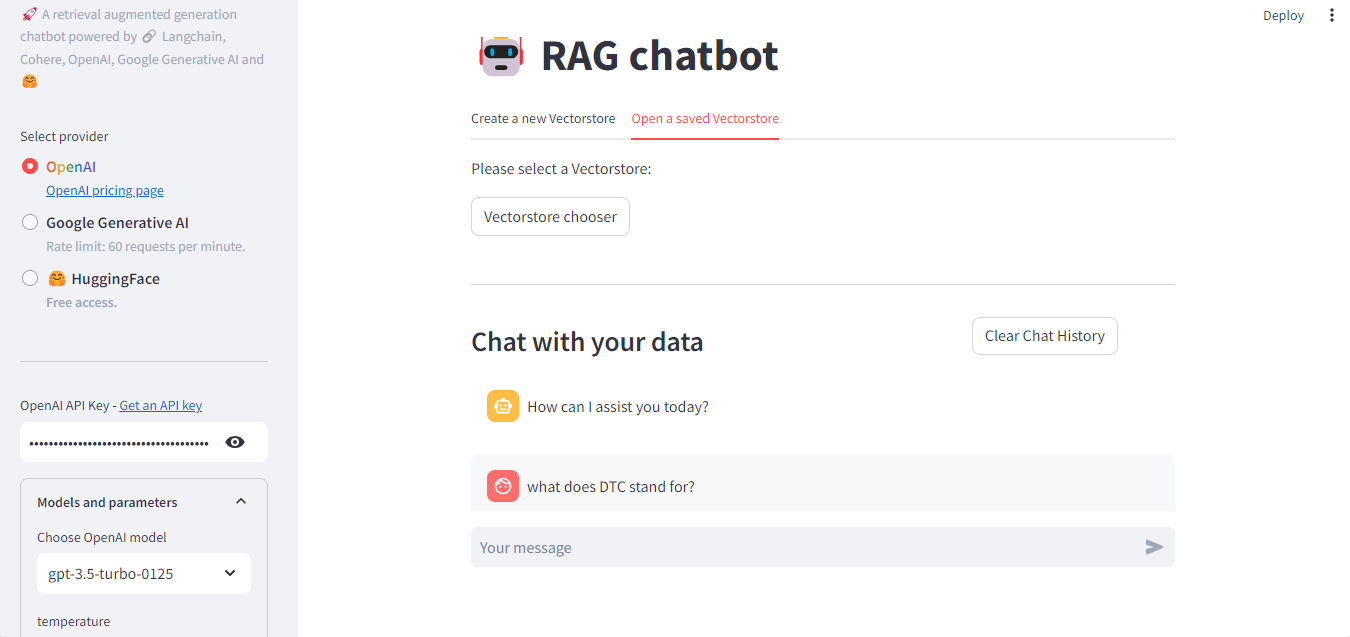

In [64]:
Image.open("./data/docs/screenshots/streamlit_app_1.png")

- In the sidebar, you can select the LLM provider, choose an LLM, adjust its parameters, and insert your API keys.

- In the main panel, you can create or load a Chroma vectorstore and display or clear the chat messages.

# <a class="anchor" id="conclusion">Concluding</a> 

In this project, we covered all the steps of creating a RAG chatbot in Langchain, from loading documents to creating a conversational retrieval chain.
Additionally, we developed a Streamlit application.

Our RAG chatbot was powered by OpenAI, Google Generative AI and Hugging Face **APIs**. An alternative option is to run open-source quantized models **[locally](https://python.langchain.com/docs/guides/local_llms)** to protect privacy and avoid inference fees. These models can be run with frameworks such as [llama.cpp](https://github.com/ggerganov/llama.cpp) and [Ollama](https://github.com/ggerganov/llama.cpp).
